In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from keras.models import load_model

# Load the model

In [15]:
model_path = "./cats_and_dogs_small_2.h5"
model = load_model(model_path)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

# Analyze the model

In [17]:
model.layers

In [18]:
for i in range(0,8):
    print(model.layers[i].input_shape)
    print(model.layers[i].output_shape)
    print("\n")

(None, 150, 150, 3)
(None, 148, 148, 32)


(None, 148, 148, 32)
(None, 74, 74, 32)


(None, 74, 74, 32)
(None, 72, 72, 64)


(None, 72, 72, 64)
(None, 36, 36, 64)


(None, 36, 36, 64)
(None, 34, 34, 128)


(None, 34, 34, 128)
(None, 17, 17, 128)


(None, 17, 17, 128)
(None, 15, 15, 128)


(None, 15, 15, 128)
(None, 7, 7, 128)




In [19]:
ll = model.trainable_weights
print(ll[0])
print(ll[1])
print(ll[2])
print(ll[3])

print(ll[4])
print(ll[5])
print(ll[6])
print(ll[7])

print(ll[8])
print(ll[9])
print(ll[10])
print(ll[11])

print(ll[12])
print(ll[13])



<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 3, 32) dtype=float32_ref>
<tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>
<tf.Variable 'conv2d_2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'conv2d_3/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 128, 128) dtype=float32_ref>
<tf.Variable 'conv2d_4/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(6272, 512) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'dense_2/kernel:0' shape=(512, 64) dtype=float32_ref>
<tf.Variable 'dense_2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense_3/kernel:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'dense_3/bias:0' shape=(1,) dtype=float32_ref>


# Load a sample image

In [20]:
from keras.preprocessing import image
import numpy as np

In [21]:
img_path = 'D:/Datasets/cats_and_dogs_small/test/cats/1577.jpg'

In [22]:
img = image.load_img(path=img_path, target_size=(150,150)) #input layer of model is (150,150,3)
print(type(img))

img_tensor = image.img_to_array(img) # convert PIL image to numpy-ndarray
print(type(img_tensor))
print(img_tensor.shape)

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(150, 150, 3)


In [23]:
img_tensor[0][0]

array([199., 176., 145.], dtype=float32)

In [24]:
img_tensor = np.expand_dims(img_tensor, axis=0) # add 4th dim for batch size
img_tensor = img_tensor /255.0

In [25]:
img_tensor[0][0]

array([[0.78039217, 0.6901961 , 0.5686275 ],
       [0.76862746, 0.6666667 , 0.5686275 ],
       [0.78039217, 0.6784314 , 0.5882353 ],
       [0.84313726, 0.73333335, 0.6509804 ],
       [0.972549  , 0.8627451 , 0.76862746],
       [0.972549  , 0.85882354, 0.7411765 ],
       [0.9843137 , 0.87058824, 0.7372549 ],
       [0.8901961 , 0.79607844, 0.69411767],
       [0.79607844, 0.7019608 , 0.6       ],
       [0.7490196 , 0.64705884, 0.5411765 ],
       [0.8       , 0.7019608 , 0.58431375],
       [0.8352941 , 0.7294118 , 0.6156863 ],
       [0.8784314 , 0.7647059 , 0.64705884],
       [0.88235295, 0.76862746, 0.6509804 ],
       [0.9647059 , 0.8509804 , 0.69411767],
       [0.96862745, 0.85490197, 0.69803923],
       [0.96862745, 0.85490197, 0.69803923],
       [0.91764706, 0.8039216 , 0.64705884],
       [0.84705883, 0.73333335, 0.5764706 ],
       [0.79607844, 0.68235296, 0.5254902 ],
       [0.75686276, 0.6431373 , 0.4862745 ],
       [0.7254902 , 0.6156863 , 0.47058824],
       [0.

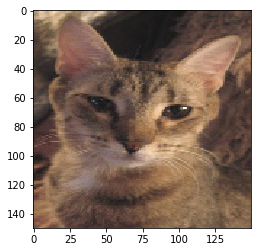

In [26]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()


### Pipeline to extract layers's output maps

In [27]:
from keras.models import Model

In [28]:
output_layers = [layers.output for layers in model.layers[:8]] # first 8 layer before we flatten them

In [29]:
activation_model = Model(inputs=model.input, outputs=output_layers) # if i understand this correctly this is one to many setting

In [30]:
activations = activation_model.predict(img_tensor)

## understand output

In [31]:
print(len(activations))

8


In [32]:
print(activations[0].shape)
print(activations[1].shape)

print(activations[3].shape)
print(activations[7].shape)

(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 36, 36, 64)
(1, 7, 7, 128)


In [33]:
# output is list of 8 activations
# each of them is is a 4D tensor

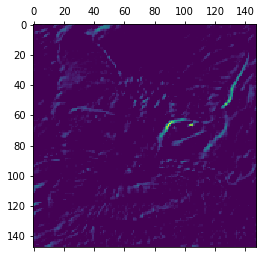

In [34]:
# Lets us plot one of them - here we take output of 0th layer
# from that we take output of image0, filter 14
plt.matshow(activations[0][0,:,:,14])

# systematically plot outputs of all layers

    - Since we have a single input image, each activation will have 1 in axis=0 
    - Number of filters for each activation will vary
    
    - extract names of all layers
    - 

In [35]:
layer_names = []

for i, layer in enumerate(model.layers[:8]):
    #print(layer.name)
    str_ = "Layer_" + str(i) + "_" + layer.name
    layer_names.append(str_)
    #print(str_)
    
print(layer_names)

['Layer_0_conv2d_1', 'Layer_1_max_pooling2d_1', 'Layer_2_conv2d_2', 'Layer_3_max_pooling2d_2', 'Layer_4_conv2d_3', 'Layer_5_max_pooling2d_3', 'Layer_6_conv2d_4', 'Layer_7_max_pooling2d_4']


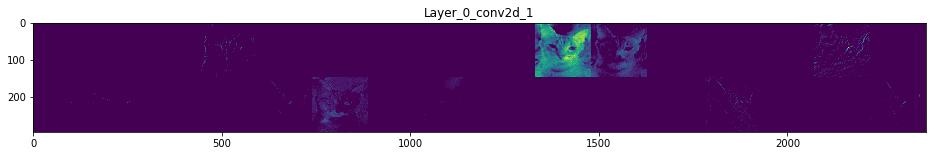

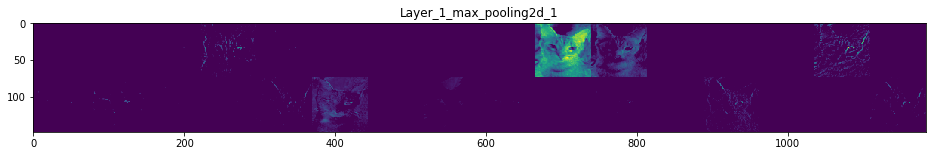

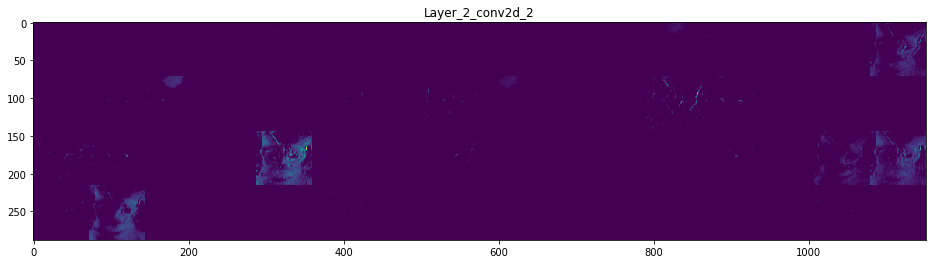

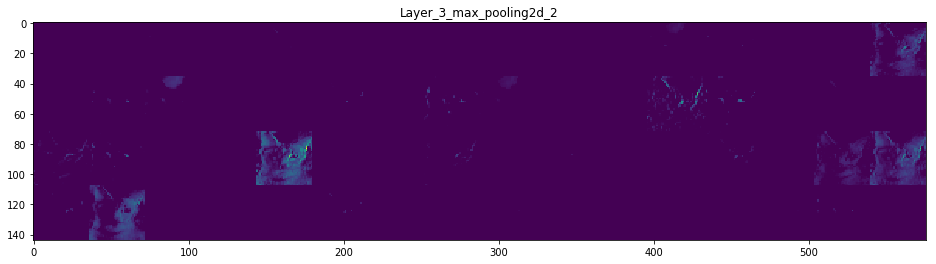

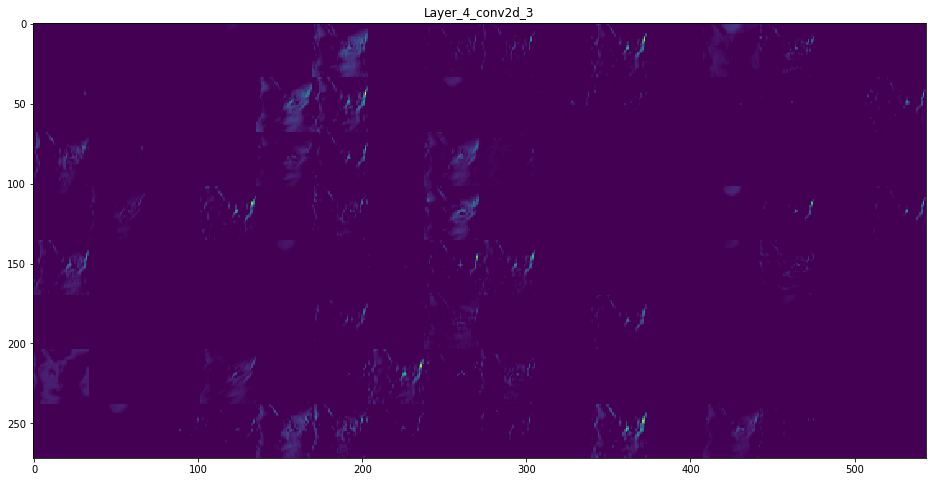

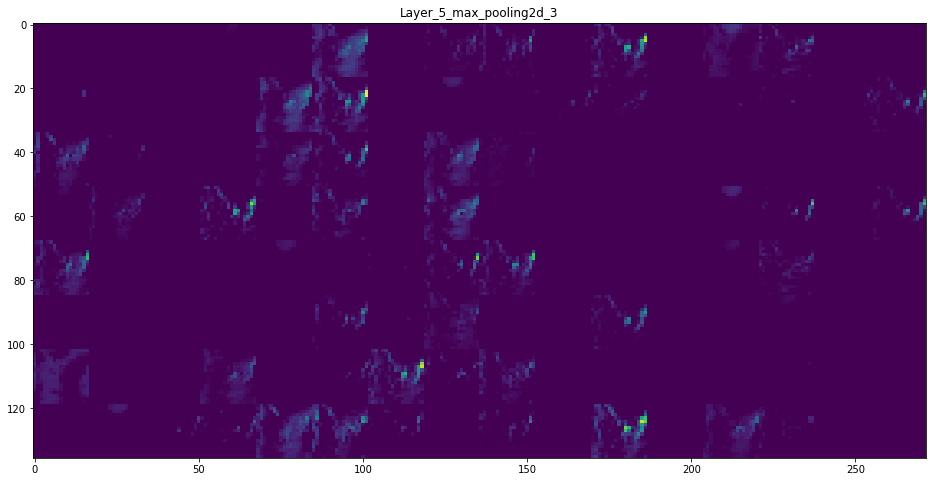

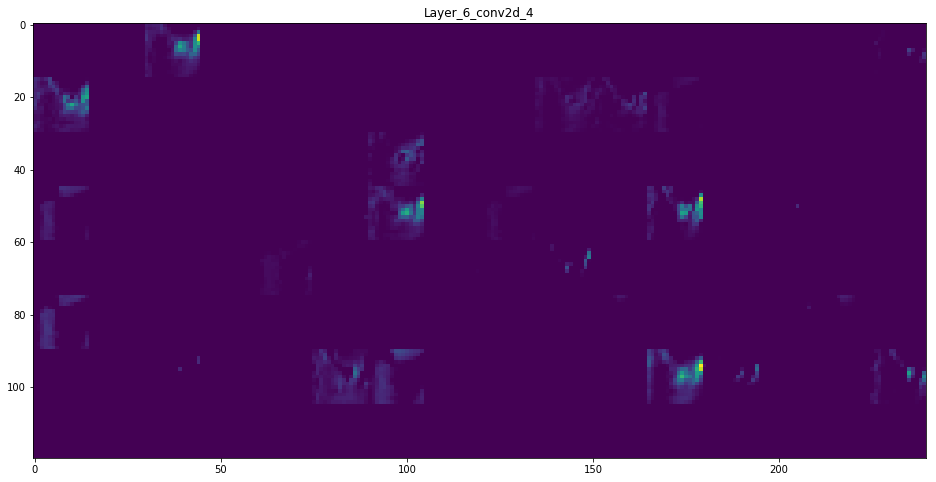

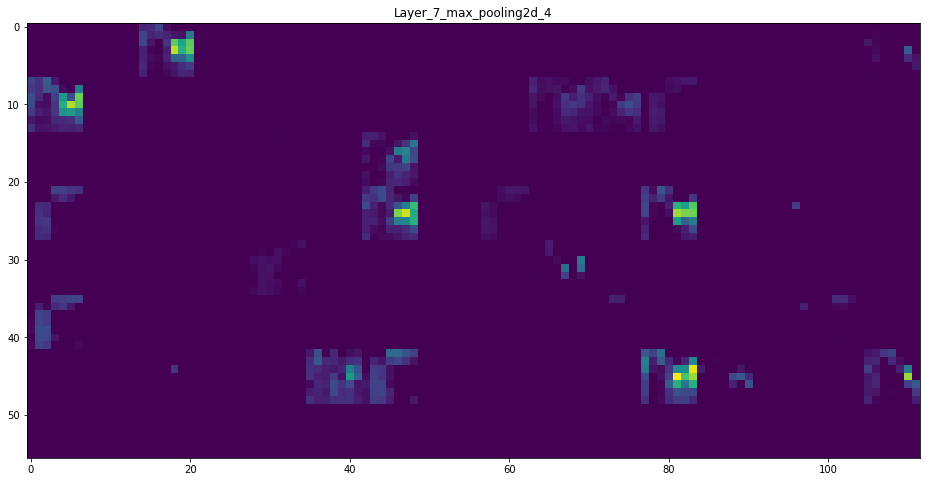

In [39]:
images_per_row = 16

for layer_name, activation in zip(layer_names, activations):
    
    # to layout the grid - we need no of rows, no of columns(this is fixed by images_per_row)
    # and size of each sqaure
    # Below we compute these
    no_of_feature_maps = activation.shape[-1]
    
    height_width = activation.shape[1]
    
    num_of_rows = no_of_feature_maps // images_per_row
    
    display_grid = np.zeros(shape=(height_width * num_of_rows, images_per_row * height_width))
    
    for row in range(num_of_rows):
        for column in range(images_per_row):
            
            channel_image = activation[0,:,:, images_per_row * row + column]
            
            
            
            display_grid[ row*height_width : (row+1)*height_width, column*height_width: (column+1)*height_width] = channel_image
            
            
    scale = 1. / height_width
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')   
    

c:\users\a00439512\appdata\local\continuum\anaconda3\envs\demo\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


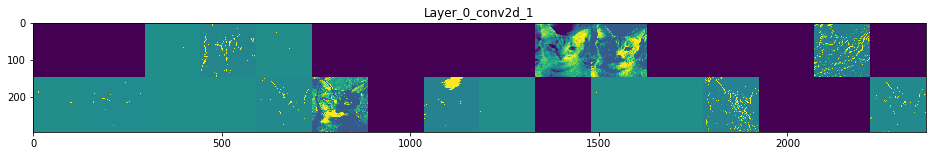

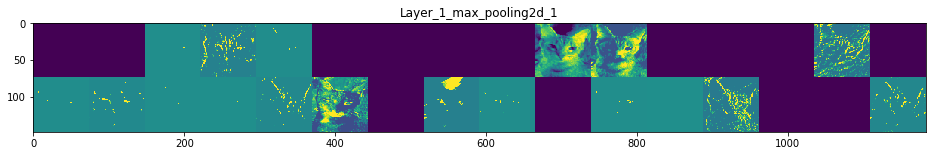

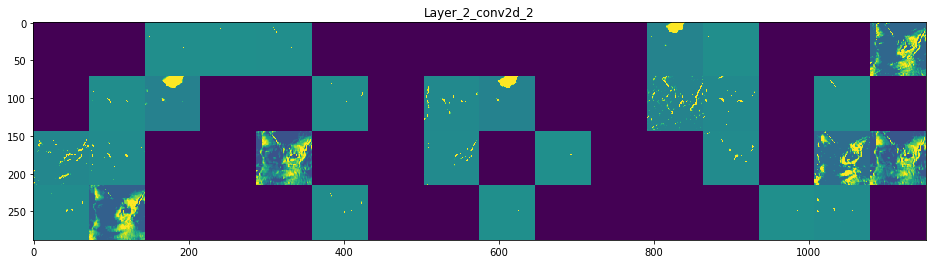

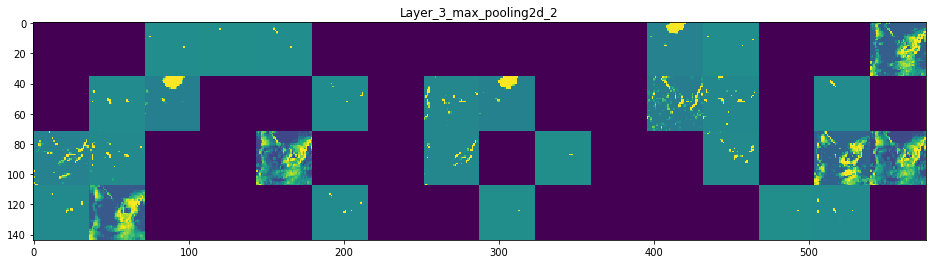

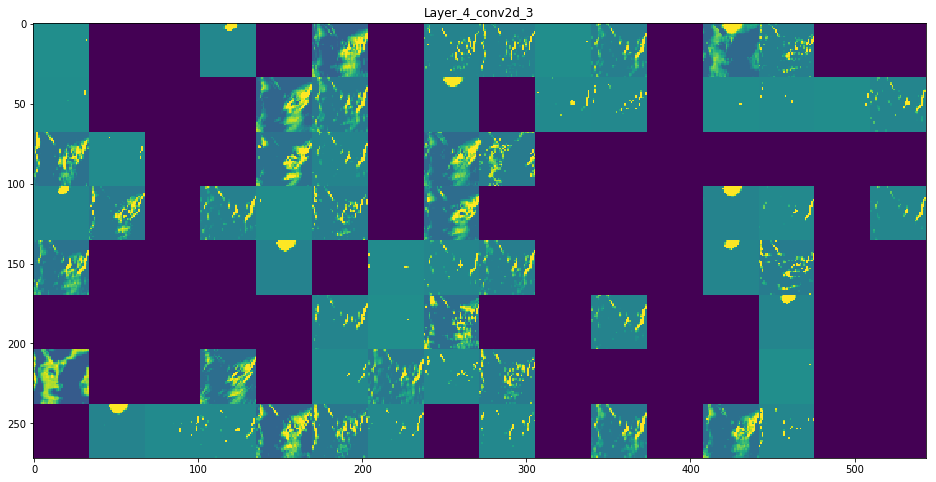

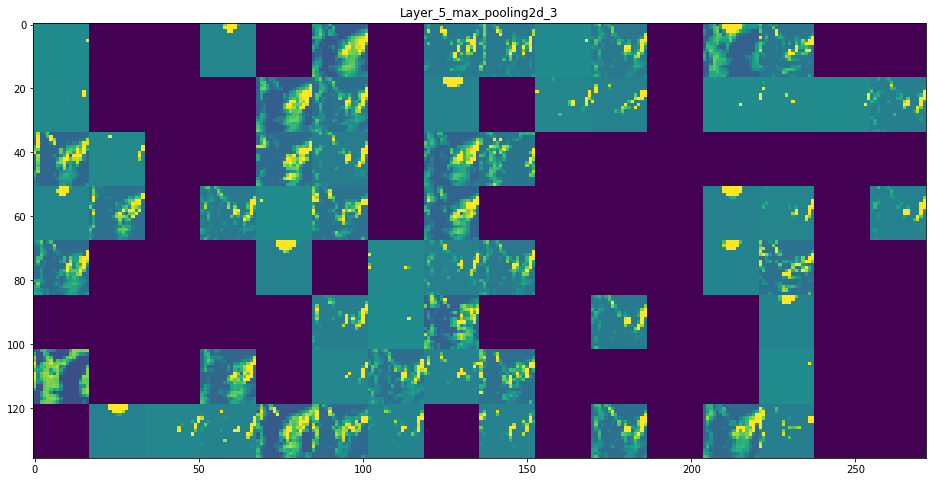

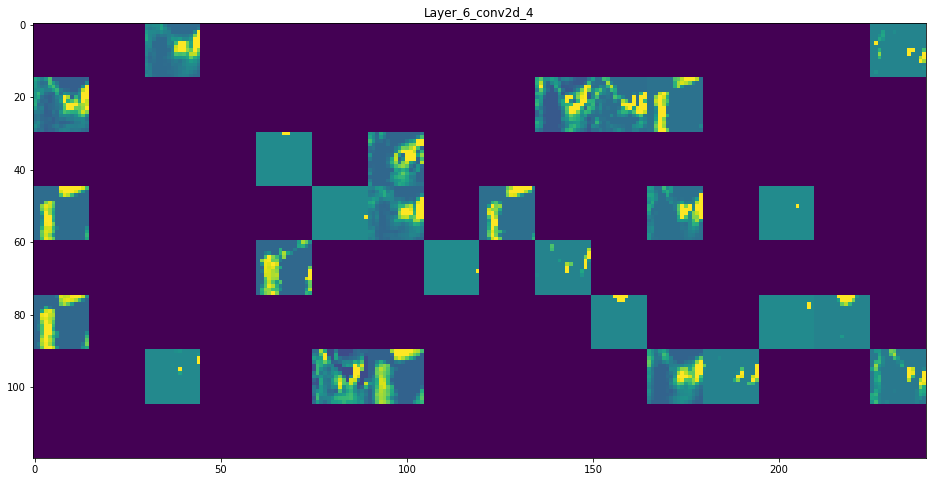

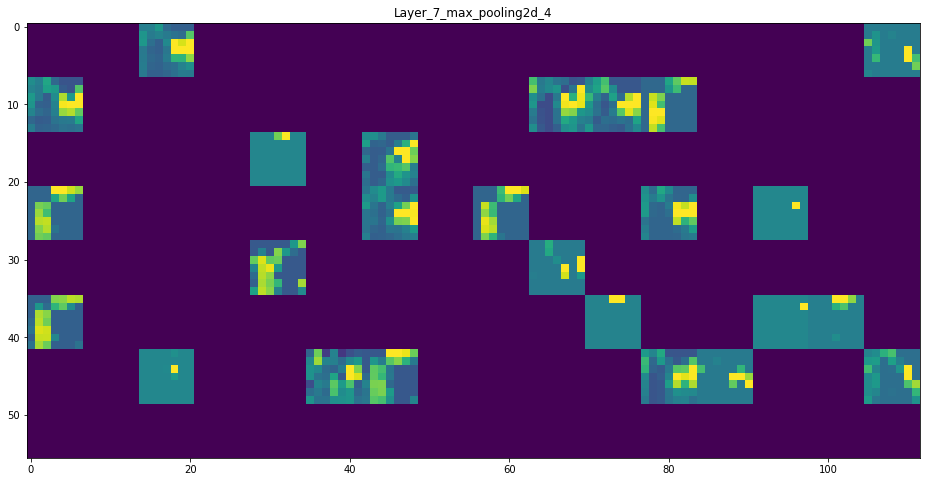

In [37]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    no_of_feature_maps = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_rows = no_of_feature_maps // images_per_row
    
    display_grid = np.zeros((size * n_rows, images_per_row * size))
    
    for row in range(n_rows):
        for col in range(images_per_row):
            channel_image = layer_activation[0,:,:,row*images_per_row+col]
            
            #normalize the image
            channel_image = channel_image - channel_image.mean()
            channel_image = channel_image / channel_image.std()
            
            channel_image *= 64
            channel_image += 128
            
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * size : (row + 1) * size, col * size : (col + 1) * size] = channel_image
            
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        